In [1]:
# Import required libraries
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.spatial.distance as sci_dist
from PIL import Image
import sys

# Configure matplotlib and numpy settings
# matplotlib.use('QtAgg')
%matplotlib inline
Image.MAX_IMAGE_PIXELS = None
np.random.seed(0)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

tools_path = '../helperScripts/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

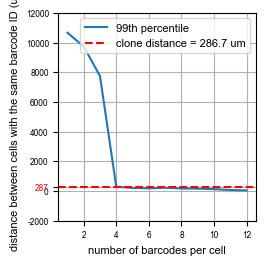

In [2]:


# Define file paths
data_folder = tools.roi_file_paths['dish_roi2']['out_path']
# data_folder = '/Users/yaelheyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/roi_2/exports'
region_data_path = '../extractedData/in_vitro/Region_Data_with_Minimal_Values.csv'
# region_data_path = '/Users/YaelHeyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/processedData/Region_Data_with_Minimal_Values.csv'
cell_by_gene_path = os.path.join(data_folder, 'cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.2thresh.csv')
data_output_folder = '../extractedData/in_vitro'
plot_output_folder = '../graphs'

def calculate_polygon_area(vertices):
    """Calculate the area of a polygon given its vertices as a NumPy array.
    
    Arguments:
    vertices -- a NumPy array of shape (N, 2), where N is the number of vertices
    
    Returns:
    The area of the polygon.
    """
    # Ensure the first vertex is also the last (to close the polygon)
    if not np.array_equal(vertices[0], vertices[-1]):
        vertices = np.vstack([vertices, vertices[0]])
    
    # Calculate the sum of the cross-products
    x0 = vertices[:-1, 0]
    y1 = vertices[1:, 1]
    y0 = vertices[:-1, 1]
    x1 = vertices[1:, 0]
    
    # Calculate the area using the shoelace formula
    area = abs(np.sum(x0 * y1) - np.sum(y0 * x1)) / 2.0
    return area

def max_dist(coords, ids):
    """Calculate maximum distance between points and enclosed area.
    
    Arguments:
    coords -- coordinate array
    ids -- indices of points to consider
    
    Returns:
    max_val -- maximum distance between any two points
    area_enclosed -- area of polygon formed by points
    """
    distance = sci_dist.pdist(coords[ids,:])
    dist_mat = sci_dist.squareform(distance)
    max_val = np.max(dist_mat)
    area_enclosed = calculate_polygon_area(coords[ids,:])
    return max_val, area_enclosed

# Load and process region data
region_data = pd.read_csv(region_data_path)
pixel2mm = 107.11 / 1000000  # Convert pixel to milimeters

# Combine data from multiple regions
combined_df = pd.DataFrame()
for j in range(1, 4):  # Process regions 1-3
    data_folder = tools.roi_file_paths[f'dish_roi{j}']['out_path']
    # data_folder = f"/Users/yaelheyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/roi_{j}/exports"
    cell_by_gene_path = os.path.join(data_folder, 'cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.2thresh.csv')
    
    # Load cell by gene data
    cell_by_gene = pd.read_csv(cell_by_gene_path, index_col=0)
    
    # Get reference coordinates
    ref_x = region_data.loc[region_data['Region'] == f"Region {j}", "Min X (mm)"].iloc[0]
    ref_y = region_data.loc[region_data['Region'] == f"Region {j}", "Min Y (mm)"].iloc[0]
    
    # Correct coordinates
    cell_by_gene['center_x'] = (cell_by_gene['center_x'] * pixel2mm + ref_x) * 1000
    cell_by_gene['center_y'] = (cell_by_gene['center_y'] * pixel2mm + ref_y) * 1000
    
    # Make cell IDs unique across regions
    cell_by_gene['cell_id'] = cell_by_gene['cell_id'] + j * 100000
    
    # Append to combined dataset
    combined_df = pd.concat([combined_df, cell_by_gene], ignore_index=True)

# Save combined dataset
combined_df.to_csv(os.path.join(data_output_folder, 'combined_df.csv'))

# Process barcode data
cell_by_gene = combined_df.copy()
coords = cell_by_gene[['center_x', 'center_y']].to_numpy()

# Create dictionary of barcode indices
barcode_indices = {}
for index, barcode in enumerate(cell_by_gene['barcode_names']):
    barcode_key = barcode if barcode == barcode else 'NaN'
    barcode_indices.setdefault(barcode_key, []).append(index)

# Calculate distances and areas for sister cells
indices_list = list(barcode_indices.values())
cell_by_gene['sisters_max_distance'] = pd.NA
cell_by_gene['sisters_enclosed_area'] = pd.NA

for ids in indices_list:
    max_dist_val, area_enclosed = max_dist(coords, ids)
    for row_index in ids:
        cell_by_gene.iloc[row_index, cell_by_gene.columns.get_loc('sisters_max_distance')] = max_dist_val
        cell_by_gene.iloc[row_index, cell_by_gene.columns.get_loc('sisters_enclosed_area')] = area_enclosed

# Filter cells that do not have barcodes or have over 12 barcodes and analyze data
filtered_df = cell_by_gene[(cell_by_gene['n_called_barcodes'] > 0) & (cell_by_gene['n_called_barcodes'] <= 12)]

# Initialize arrays for statistics
max_distance_sisters = np.array([])
mean_distance_sisters = np.array([])
median_distance_sisters = np.array([])
percentile99_distance_sisters = np.array([])
exception = np.array([])

# Calculate statistics for each number of barcodes
for num_barcodes in np.unique(filtered_df["n_called_barcodes"]):
    idx = (filtered_df["n_called_barcodes"] == num_barcodes) & (filtered_df["sisters_max_distance"] > 0)
    if filtered_df.loc[idx]["sisters_max_distance"].empty:
        exception = np.append(exception, num_barcodes)
        continue
        
    sister_distances = filtered_df.loc[idx]["sisters_max_distance"]
    max_distance_sisters = np.append(max_distance_sisters, np.max(sister_distances))
    mean_distance_sisters = np.append(mean_distance_sisters, np.mean(sister_distances))
    median_distance_sisters = np.append(median_distance_sisters, np.median(sister_distances))
    percentile99_distance_sisters = np.append(percentile99_distance_sisters, 
                                            np.percentile(sister_distances, 99))

# Plot distance statistics
# Convert 6 cm to inches
width_in = 7 / 2.54
height_in = 7 / 2.54

# Create figure of size 6 cm by 6 cm
fig, ax = plt.subplots(figsize=(width_in, height_in))

x = np.setdiff1d(np.unique(filtered_df["n_called_barcodes"]), exception)

# Plotting the 99th percentile distance
f4, = plt.plot(x, percentile99_distance_sisters, label='99th percentile')

# Find the y-value corresponding to x = 4
if 4 in x:
    y_value = percentile99_distance_sisters[np.where(x == 4)][0]
    plt.axhline(y=y_value, color='red', linestyle='--', label=f'clone distance = {y_value:.1f} um')

ax.tick_params(axis='both', which='major', labelsize=6)

# Create legend with 8-pt text
ax.legend(fontsize=8,loc='upper right')

# Optional: Set axis labels if needed
ax.set_xlabel("number of barcodes per cell", fontsize=8)
ax.set_ylabel("distance between cells with the same barcode ID (um)", fontsize=8)
special_tick = y_value

# 1. Get the current y-ticks
current_yticks = list(ax.get_yticks())

# 2. Add the new tick, then sort the list
current_yticks.append(special_tick)
current_yticks.sort()

# 3. Update the axis ticks
ax.set_yticks(current_yticks)

# Create string labels for each tick
labels_str = [f'{val:.0f}' for val in current_yticks]

# 4. Apply these labels and color the special one red
label_objects = ax.set_yticklabels(labels_str)
special_index = current_yticks.index(special_tick)
label_objects[special_index].set_color('red')
# Tight layout for better spacing
plt.tight_layout()
plt.grid(True)

# plt.savefig(os.path.join(output_folder, 'num_bc_vs_sisterhood_dist.pdf'),bbox_inches="tight")
plt.savefig(os.path.join(plot_output_folder, 'num_bc_vs_sisterhood_dist.pdf'),bbox_inches="tight")
# plt.show()


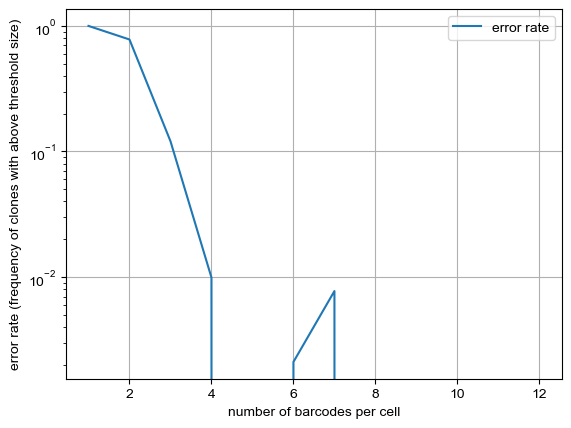

In [3]:
# Calculate and plot error rates
thresh_dist = y_value #above this distance the sisterhood would be considered to have an error
error_rate_num_bc = np.array([])

for num_barcodes in np.unique(filtered_df["n_called_barcodes"]):
    idx = (filtered_df["n_called_barcodes"] == num_barcodes) & (filtered_df["sisters_max_distance"] > 0)
    if filtered_df.loc[idx]["sisters_max_distance"].empty:
        continue
    
    error_rate = np.sum(filtered_df.loc[idx]["sisters_max_distance"] > thresh_dist)/len(filtered_df.loc[idx]["sisters_max_distance"])
    error_rate_num_bc = np.append(error_rate_num_bc, error_rate)

# Plot error rates
plt.figure()
x = np.setdiff1d(np.unique(filtered_df["n_called_barcodes"]), exception)
plt.plot(x, error_rate_num_bc, label='error rate')
plt.yscale("log")
plt.legend()
plt.ylabel('error rate (frequency of clones with above threshold size)')
plt.xlabel('number of barcodes per cell')
plt.grid(True)
# plt.show()

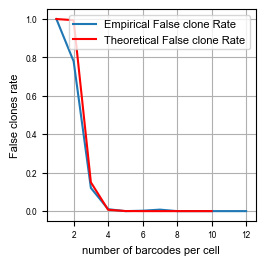

In [4]:
# Calculate cumulative error rates and theoretical error rates
error_rate_num_bc = np.array([])
percentage_more_than = np.array([])

for num_barcodes in np.unique(filtered_df["n_called_barcodes"]):
    idx = (filtered_df["n_called_barcodes"] ==num_barcodes) & (filtered_df["sisters_max_distance"] > 0)
    
    if filtered_df.loc[idx]["sisters_max_distance"].empty:
        exception = np.append(exception, num_barcodes)
        continue
    
    # Calculate empirical error rate
    error_rate = np.sum(filtered_df.loc[idx]["sisters_max_distance"] > thresh_dist) / len(filtered_df.loc[idx]["sisters_max_distance"])
    error_rate_num_bc = np.append(error_rate_num_bc, error_rate)
    
    # Calculate percentage of cells with more than current number of barcodes
    percentage = np.sum(idx) / len(filtered_df["n_called_barcodes"] >= 0)
    percentage_more_than = np.append(percentage_more_than, percentage)

# Calculate theoretical error rates
n = len(combined_df["barcode_names"].unique())
bc_lib_size = 96
error_rates = []

for num_bc in range(1, 11):
    N = math.comb(bc_lib_size, num_bc)
    error_rate = 1 - (1 - 1/N)**(n-1)
    error_rates.append(error_rate)

# Plot empirical vs theoretical error rates
width_in = 7 / 2.54
height_in = 7 / 2.54

# Create figure of size 6 cm by 6 cm
fig, ax = plt.subplots(figsize=(width_in, height_in))
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.98)

x = np.setdiff1d(np.unique(filtered_df["n_called_barcodes"]), exception)
f1, = plt.plot(x, error_rate_num_bc, label='Empirical False clone Rate')
f2, = plt.plot(range(1, 11), error_rates, 'r', label='Theoretical False clone Rate')

ax.tick_params(axis='both', which='major', labelsize=6)

# Create legend with 8-pt text
ax.legend(fontsize=8,loc='upper right')

plt.ylabel('False clones rate', fontsize=8)
plt.xlabel('number of barcodes per cell',fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(plot_output_folder, 'expected vs measured false clone rate.pdf'),bbox_inches="tight")
plt.show()

In [5]:
num_clones_statistics = pd.DataFrame()
num_clones_statistics.loc['all_rois', "num_cells"] = len(combined_df)
num_clones_statistics.loc['all_rois', "num_clones"] = n
for j in range(1, 4):  # Process regions 1-3
    # data_folder = f"/Users/yaelheyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/roi_{j}/exports"
    data_folder = tools.roi_file_paths[f'dish_roi{j}']['out_path']
    cell_by_gene_path = os.path.join(data_folder, 'cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.2thresh.csv')
    
    # Load cell by gene data
    cell_by_gene = pd.read_csv(cell_by_gene_path, index_col=0)
    clones = len(cell_by_gene["barcode_names"].unique())
    cells = len(cell_by_gene)
    num_clones_statistics.loc[f'roi_{j}', "num_cells"] = cells
    num_clones_statistics.loc[f'roi_{j}', "num_clones"] = clones
num_clones_statistics.to_csv(os.path.join(data_output_folder, 'num_clones_statistics.csv'))    

In [6]:
x = np.setdiff1d(np.unique(filtered_df["n_called_barcodes"]), exception)
error_rate_num_bc = np.array([])
percentage_more_than = np.array([])
for num_barcodes in np.unique(filtered_df["n_called_barcodes"]):
    idx = (filtered_df["n_called_barcodes"] >= num_barcodes) & (filtered_df["sisters_max_distance"] > 0)
    
    if filtered_df.loc[idx]["sisters_max_distance"].empty:
        exception = np.append(exception, num_barcodes)
        continue
    
    # Calculate empirical error rate
    error_rate = np.sum(filtered_df.loc[idx]["sisters_max_distance"] > thresh_dist) / len(filtered_df.loc[idx]["sisters_max_distance"])
    error_rate_num_bc = np.append(error_rate_num_bc, error_rate)
    
    # Calculate percentage of cells with more than current number of barcodes
    percentage = np.sum(idx) / len(filtered_df["n_called_barcodes"] >= 0)
    percentage_more_than = np.append(percentage_more_than, percentage)

# Save error rate data
error_rate_df = pd.DataFrame({
    "num bc": x,
    "error_rate": error_rate_num_bc
})
error_rate_df.to_csv(os.path.join(data_output_folder, 'error_rate_equal_to_or_more.csv'))